In [ ]:
"""
Example of an VAE/CVAE training a simple circle dataset using the radius as conditioning

Example dataset inspired by Cornelius Braun, TU Berlin

Written by Christoph Scherer, TU Berlin
"""

import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from vae import CVAE
from generative_model import CustomDataset

tensor([1., 2., 3., 4.])
torch.Size([256, 2]) 2
torch.Size([256, 1]) 1


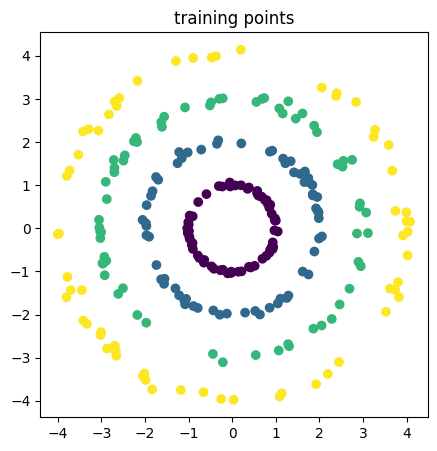

In [2]:
""" Generate training/test data """
n_points = 64
radius = torch.Tensor([1.0, 2.0, 3.0, 4.0])
#radius = torch.Tensor([1.0, 3.0])

print(radius)
noise_factor = .025

theta = torch.rand((n_points, len(radius)))*2*np.pi
x = radius*(torch.cos(theta) + torch.randn_like(theta)*noise_factor)
y = radius*(torch.sin(theta) + torch.randn_like(theta)*noise_factor)

# training points are the circle samples with features x, y
# labels/conditioning are the corresponding radii
training_points = torch.stack([x.T.ravel(), y.T.ravel()], dim=1)
training_labels = radius.repeat(n_points,1).T.ravel().unsqueeze(dim=1)

n_point_features = training_points.shape[1]
n_label_features = training_labels.shape[1]

print(training_points.shape, n_point_features)
print(training_labels.shape, n_label_features)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(training_points[:,0], training_points[:,1], c=training_labels)
ax.set_title('training points')
plt.show()

In [3]:
batch_size = 64
# training data
training_dataset = CustomDataset(points=training_points, labels=training_labels)
training_dataset.__getitem__(0)
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

In [4]:
def give_weights(n_epochs: int, start: float = 0.5, stop: float = 0.9, final_ratio: float = 0.1, normalize: bool = False) -> torch.Tensor:
    """gives weights for KL annealing schedule (beta annealing)

    - idea: S. R. Bowman, L. Vilnis, O. Vinyals, A. M. Dai, R. Jozefowicz, und S. Bengio, „Generating Sentences from a Continuous Space“. arXiv, 12. Mai 2016. Zugegriffen: 27. März 2024. [Online]. Verfügbar unter: http://arxiv.org/abs/1511.06349
    - my idea: normalize weights

    Args:
        n_epochs (int): one set of weight per epoch
        start (float): start in percent of whole training schedule to start beta annealing
        stop (float): end in percent of whole training schedule to stop beta annealing
        final_ratio (float): final ratio 
        normalize (bool, optional): normalize weights s.t. w_1**2 + w_2**2 = 1. Defaults to False.

    Returns:
        torch.Tensor: stacked weights
    """
    x = torch.linspace(0, 1, n_epochs)
    
    # Determine the interval and offset for the logistic function
    dx = stop - start
    offset = start + dx / 2
    k = 10 / dx  # Logistic growth rate
    
    # Calculate the initial weights using a sigmoid function
    w_1 = torch.sigmoid(k * (x - offset))
    
    # Calculate w_2 as a constant 1 initially (we will adjust it later)
    w_2 = torch.ones_like(w_1)
    
    # Enforce the final ratio w1/w2 at the last epoch
    w_1_final = final_ratio * w_2[-1]  # Since w_2 is initially 1, w_2[-1] = 1
    scaling_factor = w_1_final / w_1[-1]
    
    # Scale the entire w_1 sequence
    w_1 *= scaling_factor
    
    # If normalization is required, normalize w_1 and w_2
    if normalize:
        norm_factor = torch.sqrt(w_1**2 + w_2**2)
        w_1 /= norm_factor
        w_2 /= norm_factor
    
    # Stack the weights and return them as a tensor
    w = torch.stack([w_1, w_2], dim=1)
    return w

Using cuda device


encoder device: cuda
decoder device: cuda
encoder device: cuda
decoder device: cuda


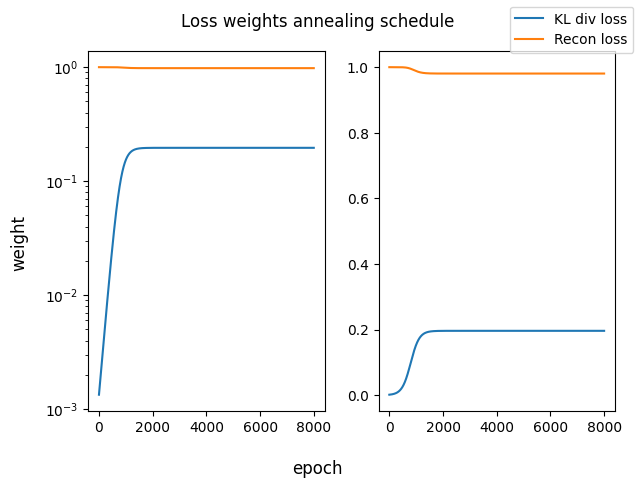

In [5]:
""" Training """

# set hyperparameter 
vae = CVAE(n_point_features=n_point_features, 
           n_label_features=n_label_features, 
           n_latent_dims=128, 
           n_hidden_encode=512, 
           n_hidden_decode=512,
           n_hidden_layers_encode=30,
           n_hidden_layers_decode=30)

## Run training
n_epochs = 8000
learning_rate = 1e-4


print_training = True

# manual weights for the loss function
#weight_schedule = np.vstack(n_epochs*[[0.1,1]]) # [KL_div_loss, Recon_loss]
weight_schedule = give_weights(n_epochs, start=0.0, stop=0.2, final_ratio=0.2, normalize=True)

fig, ax = plt.subplots(1,2)
fig.suptitle('Loss weights annealing schedule')
ax[0].semilogy(weight_schedule, label=('KL div loss', 'Recon loss'))
ax[1].plot(weight_schedule, label=('KL div loss', 'Recon loss'))
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.supxlabel('epoch')
fig.supylabel('weight')
plt.tight_layout()
plt.show()

Epoch 800,	 Loss 0.395884 
Epoch 1600,	 Loss 0.697089 
Epoch 2400,	 Loss 0.769220 
Epoch 3200,	 Loss 0.685471 
Epoch 4000,	 Loss 0.686945 
Epoch 4800,	 Loss 0.730819 
Epoch 5600,	 Loss 0.735202 
Epoch 6400,	 Loss 0.658826 
Epoch 7200,	 Loss 0.717794 
Epoch 8000,	 Loss 0.648395 


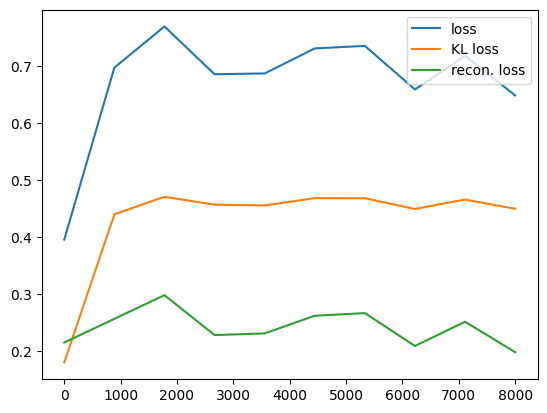

In [6]:
# train with schedule / manual weights
mean_losses, mean_loss_terms = vae.train(training_loader=training_loader, 
                                         n_epochs=n_epochs, 
                                         weight_schedule=weight_schedule,
                                         learning_rate=learning_rate)

plt.plot(np.linspace(0, n_epochs, len(mean_losses)), mean_losses, label='loss')
plt.plot(np.linspace(0, n_epochs, len(mean_losses)), mean_loss_terms[:,0], label='KL loss')
plt.plot(np.linspace(0, n_epochs, len(mean_losses)), mean_loss_terms[:,1], label='recon. loss')
plt.legend()
plt.show()

(64, 2)


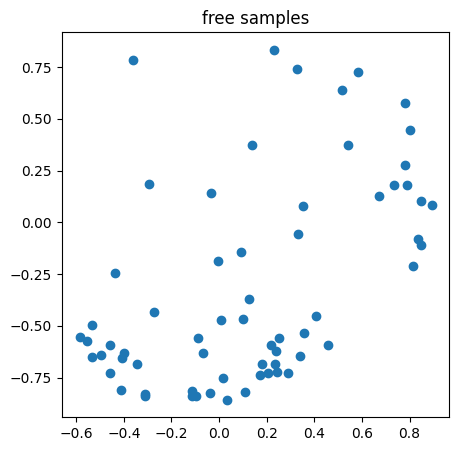

In [7]:
""" Sampling """

# example sampling
n_samples = 64

# free sampling

samples = vae.sample(n_samples=n_samples).detach().cpu().numpy()
print(samples.shape)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(samples[:,0], samples[:,1])
ax.set_title('free samples')
plt.show()

torch.Size([256])
(256, 2)


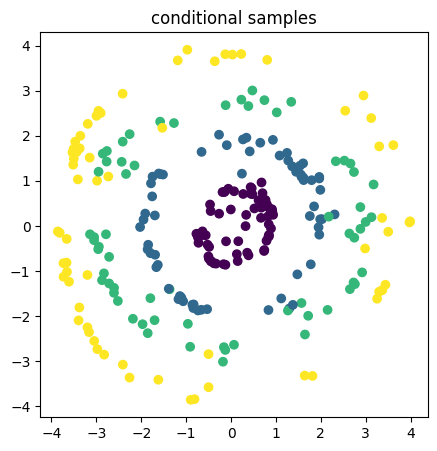

In [9]:
# conditional sampling
n = radius.shape[0]
y = (radius*torch.ones(n_samples,n)).ravel()
#y = 1.0*torch.ones_like(y)

print(y.shape)

samples = vae.sample(n_samples=y.shape[0], y=y.unsqueeze(1)).detach().cpu().numpy()
#samples = vae.sample(n_samples=128,).detach().cpu().numpy()
print(samples.shape)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(samples[:,0], samples[:,1], c=y)
ax.set_title('conditional samples')
plt.show()